In [13]:
import requests
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

### DATA

In [5]:
twotci = pd.read_parquet("../../db/tw/ind/TWOTCI.parquet").iloc[:, :-1]
twotci['ticker'] = "TWOTCI"
twse = pd.read_parquet("../../db/tw/ind/TWSE.parquet")
twse['ticker'] = "TWSE"
df = pd.concat([twse, twotci], axis=0)
price = "open"
filtered_df = df.copy()
filtered_df['AvgPrice'] = (filtered_df['high'] + filtered_df['low']) / 2
filtered_df['Return'] = filtered_df.groupby('ticker')['AvgPrice'].pct_change()
filtered_df['beta'] = filtered_df.groupby('ticker')[price].pct_change().shift(-1)
def rolling_std(group):
    group['return_stddev'] = group['Return'].rolling(window=5).std() * 100
    return group

filtered_df = filtered_df.groupby('ticker').apply(rolling_std).reset_index(level='ticker', drop=True)

def calculate_moving_averages(df):
    df['MA20'] = df[price].rolling(window=20).mean()
    df['MA60'] = df[price].rolling(window=60).mean()
    return df

filtered_df = filtered_df.groupby('ticker').apply(calculate_moving_averages).reset_index(level='ticker', drop=True)
start_date = '2015-01-01'
twse = filtered_df[(filtered_df['ticker'] == 'TWSE') & (filtered_df.index >= start_date)][[price, 'AvgPrice', "Return", "beta", "return_stddev", "MA20", "MA60"]]
twotci = filtered_df[(filtered_df['ticker'] == 'TWOTCI') & (filtered_df.index >= start_date)][[price, 'AvgPrice', "Return", "beta", "return_stddev", "MA20", "MA60"]]
twotci.reset_index(inplace=True)
twotci['da'] = pd.to_datetime(twotci['da'])
twse.reset_index(inplace=True)
twse['da'] = pd.to_datetime(twse['da'])

### Backtest start

In [6]:
import numpy as np
def calculate_twotci_metrics(row):
    date = row['da']
    twotci_today = twotci[twotci['da'] == date]
    twotci_next = twotci[twotci['da'] > date].sort_values(by='da').head(1)

    if not twotci_today.empty and not twotci_next.empty:
        twotci_beta = twotci_next[price].values[0] / twotci_today[price].values[0] - 1
    else:
        twotci_beta = np.nan
    
    twotci_return_stddev = twotci[(twotci['da'] >= (pd.to_datetime(date) - pd.Timedelta(days=5))) & (twotci['da'] <= date)]['Return'].std() * 100
    twotci_ma20 = twotci[twotci['da'] <= date].sort_values(by='da', ascending=False).head(20)[price].mean()
    twotci_ma60 = twotci[twotci['da'] <= date].sort_values(by='da', ascending=False).head(60)[price].mean()
    twotci_cl = twotci_today[price].values[0] if not twotci_today.empty else np.nan
    
    return pd.Series([twotci_beta, twotci_return_stddev, twotci_ma20, twotci_ma60, twotci_cl])

final_df = twse.copy()
final_df[['TWOTCI_BETA', 'TWOTCI_RETURN_STDDEV', 'TWOTCI_MA20', 'TWOTCI_MA60', 'TWOTCI_CL']] = final_df.apply(calculate_twotci_metrics, axis=1)
final_df.set_index('da', inplace=True, drop=False)
final_df.columns


Index(['da', 'open', 'AvgPrice', 'Return', 'beta', 'return_stddev', 'MA20',
       'MA60', 'TWOTCI_BETA', 'TWOTCI_RETURN_STDDEV', 'TWOTCI_MA20',
       'TWOTCI_MA60', 'TWOTCI_CL'],
      dtype='object')

In [7]:
real_exposure = []
classification = []
final_df['TWOTCI_RETURN_STDDEV_PREV'] = final_df['TWOTCI_RETURN_STDDEV'].shift(1)
for index, row in final_df.iterrows():
    if row['TWOTCI_RETURN_STDDEV'] <= 3 and row['TWOTCI_CL'] > row['TWOTCI_MA20']:
        real_exposure.append(True)
        classification.append(1)
        flag = "波動牛📈"
    elif row['TWOTCI_RETURN_STDDEV'] <= 1 or row['return_stddev'] >= 3.5:
        real_exposure.append(True)
        classification.append(2)
        flag = "穩定牛📈"
    elif (row['TWOTCI_RETURN_STDDEV']-row['TWOTCI_RETURN_STDDEV_PREV']) > 0.5 and row['TWOTCI_CL'] > row['TWOTCI_MA60'] and row['TWOTCI_CL'] < row['TWOTCI_MA20']:
        real_exposure.append(True)
        classification.append(3)
        flag = "抄底牛📈"
    else:
        real_exposure.append(False)
        classification.append(4)
        flag = "害怕熊📉"
    # print(str(index)+' '+str(row['TWOTCI_RETURN_STDDEV']) + str(row['TWOTCI_RETURN_STDDEV']-row['TWOTCI_RETURN_STDDEV_PREV']))
final_df['signal_ed'] = real_exposure
final_df['classification'] = classification


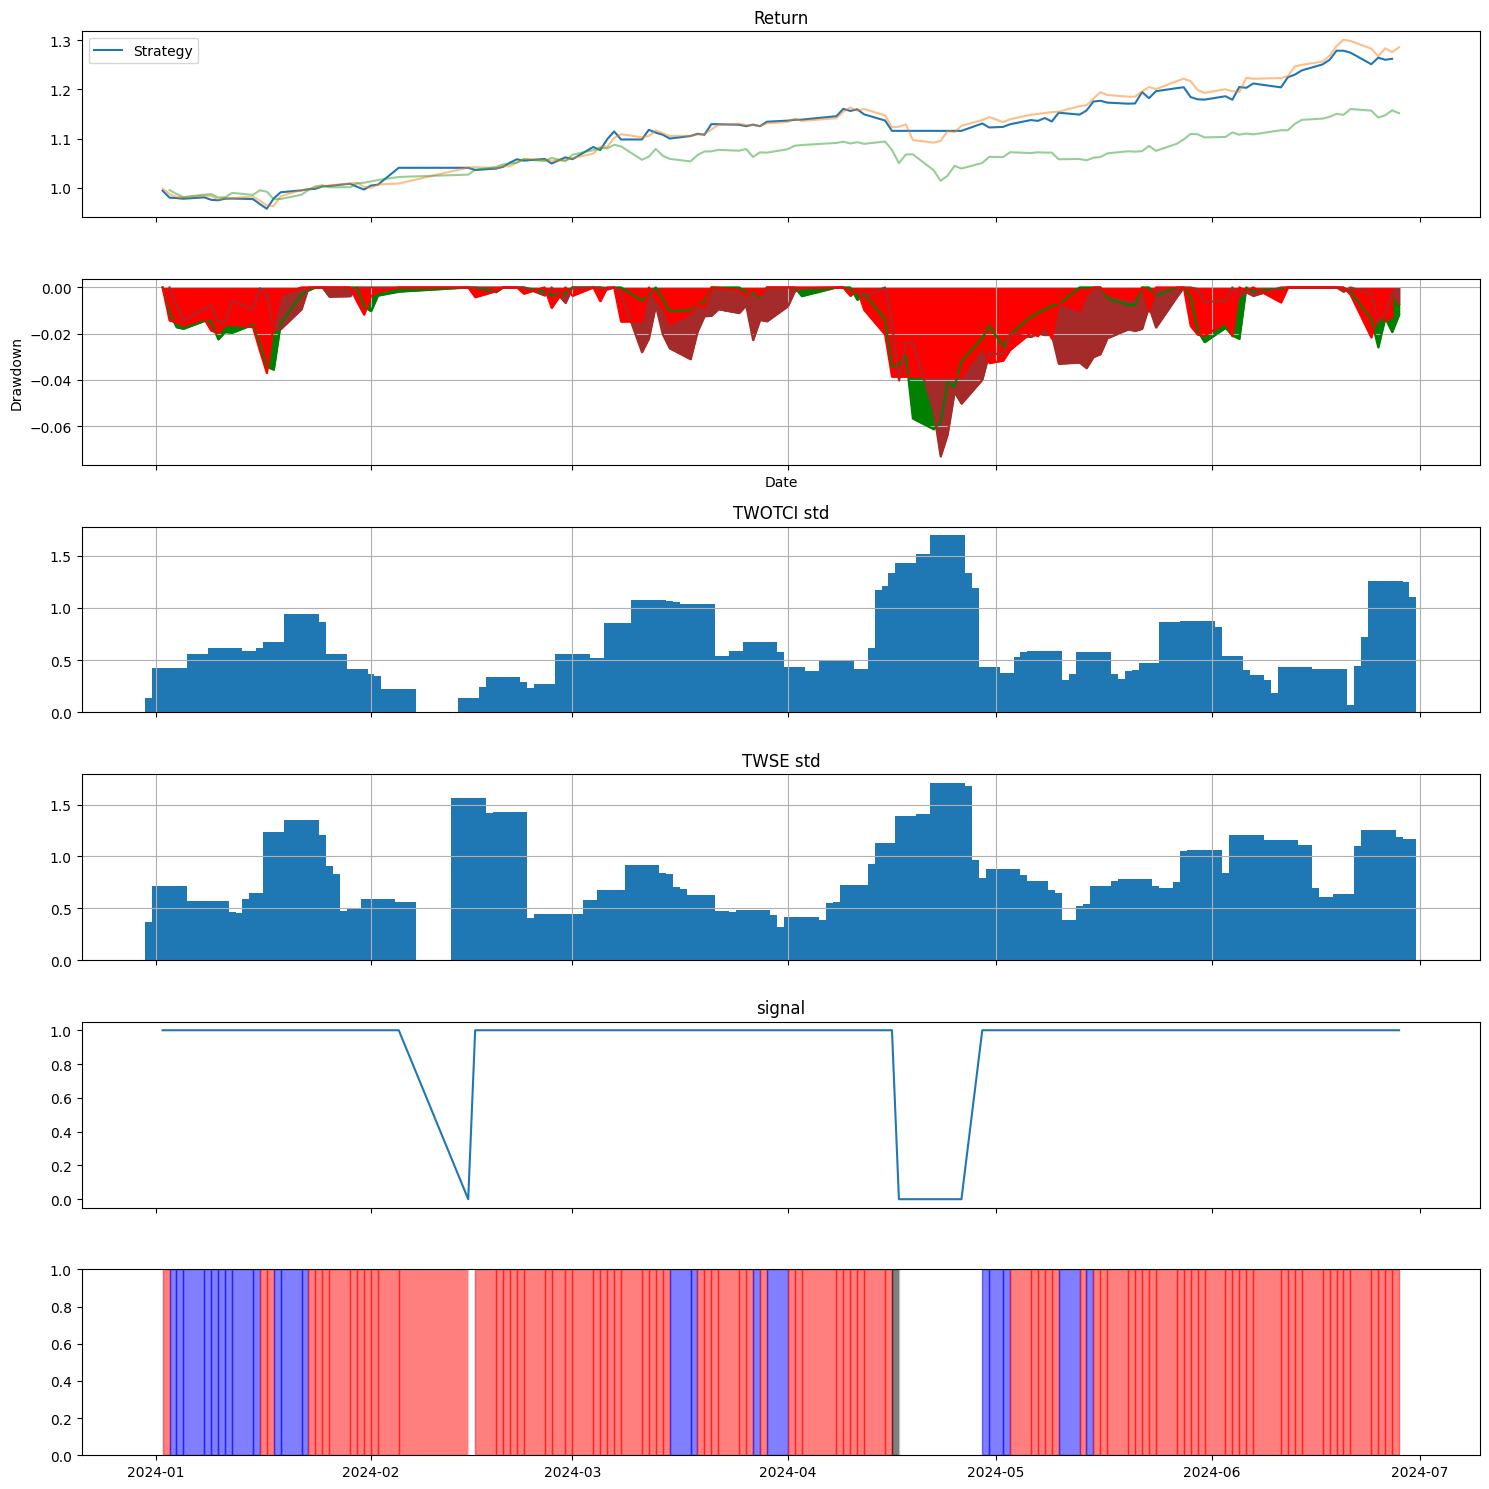

da
2024-06-24    1.251149
2024-06-25    1.264569
2024-06-26    1.260233
2024-06-27    1.262261
2024-06-28         NaN
Name: cumprod_final_signal, dtype: float64

In [14]:
# long short
import matplotlib.pyplot as plt
def calculate_return_on_signal(row, signal_col='final_signal'):
    return row['pct_change'] if row[signal_col] else 0

final_df['pct_change'] = final_df[price].pct_change().shift(-1)

final_df['final_signal1'] = final_df['signal_ed'].shift(1)
final_df['final_signal2'] = final_df['signal_ed'].shift(2)
final_df['final_signal3'] = final_df['signal_ed'].shift(3)
final_df['final_signal4'] = final_df['signal_ed'].shift(4)
final_df['signals'] = (final_df['signal_ed'])# & (final_df['final_signal1']) & (final_df['final_signal2']) & (final_df['final_signal3']) & (final_df['final_signal4'])

final_df_da = final_df[final_df['da'] >='2024-01-01']
final_df_da['daily_ret_final_signal'] = final_df_da.apply(calculate_return_on_signal, args=("signals",), axis=1)
final_df_da['cumprod_final_signal'] = (1+final_df_da['daily_ret_final_signal']).cumprod()

fig, ax = plt.subplots(6, 1, figsize=(15, 15), sharex=True)
twse_cumprod = (1+final_df_da['Return']).cumprod()
twotci_cumprod = (1+final_df_da['TWOTCI_CL'].pct_change()).cumprod()
ax[0].plot(final_df_da.index, final_df_da['cumprod_final_signal'], label='Strategy')
ax[0].plot(final_df_da.index, twse_cumprod, alpha=0.5)
ax[0].plot(final_df_da.index, twotci_cumprod, alpha=0.5)
ax[0].legend()
ax[0].set_title('Return')

def from_nav_to_mdd(nav_all):
    Roll_Max = nav_all.rolling(len(nav_all), min_periods=1).max()
    Daily_Drawdown = nav_all/Roll_Max - 1.0
    return Daily_Drawdown
    
mdd = from_nav_to_mdd(twse_cumprod)
ax[1].plot(final_df_da.index,mdd, label='TWSE', color='green')
ax[1].fill_between(final_df_da.index, mdd, color='green')
    
mdd = from_nav_to_mdd(twotci_cumprod)
ax[1].plot(final_df_da.index,mdd, label='TWOTCI', color='brown')
ax[1].fill_between(final_df_da.index, mdd, color='brown')
    
mdd = from_nav_to_mdd(final_df_da['cumprod_final_signal'])
ax[1].plot(final_df_da.index,mdd, label='Strategy', color='red')
ax[1].fill_between(final_df_da.index, mdd, color='red')
ax[1].set_ylabel('Drawdown')
ax[1].set_xlabel('Date')
ax[1].grid()

ax[2].set_title("TWOTCI std")
ax[2].bar(final_df_da.index, final_df_da['TWOTCI_RETURN_STDDEV'],width=5)
ax[2].grid()

ax[3].set_title("TWSE std")
ax[3].bar(final_df_da.index, final_df_da['return_stddev'], width=5)
ax[3].grid()

ax[4].set_title("signal")
ax[4].plot(final_df_da['da'], final_df_da['signals'])

color_dict = {
    1: "red",
    2: "blue",
    3: "black",
    4: "white"
}

for i in range(len(final_df_da)-1):
    color = color_dict[final_df_da['classification'].iloc[i]]
    ax[5].axvspan(final_df_da.index[i], final_df_da.index[i+1], color=color, alpha=0.5)
plt.tight_layout()
plt.show()
final_df_da['cumprod_final_signal'].tail()

### Specific Timeframe CtoC/ OtoO

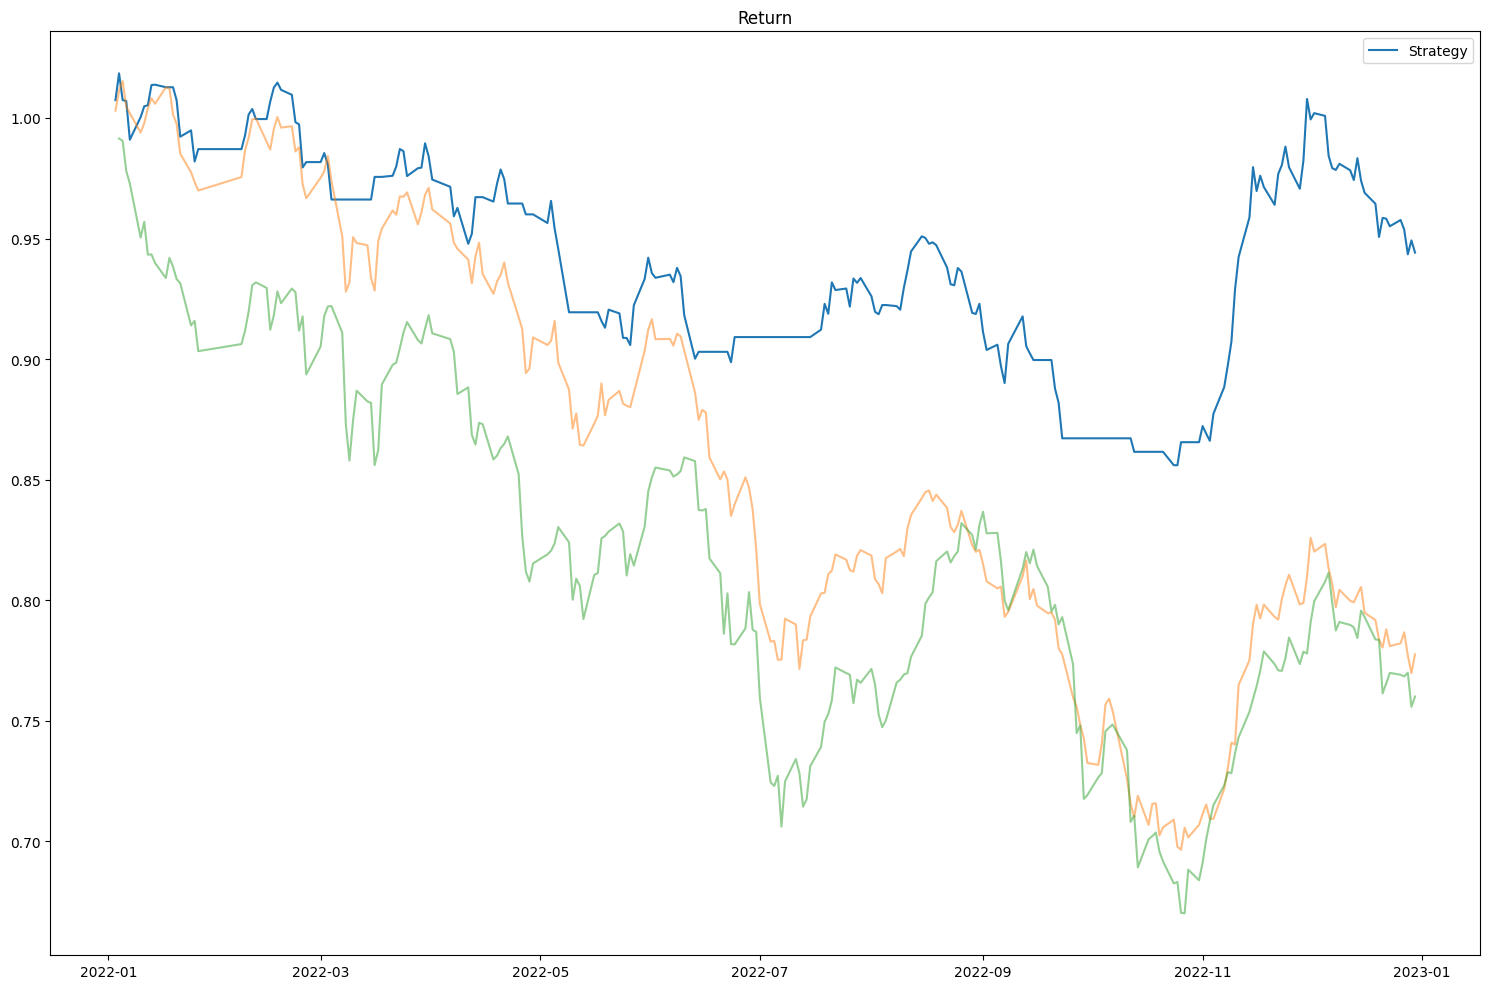

da
2022-12-26    0.957690
2022-12-27    0.953651
2022-12-28    0.943457
2022-12-29    0.949213
2022-12-30    0.944170
Name: cumprod_final_signal, dtype: float64

In [16]:
# long short

import matplotlib.pyplot as plt

final_df['pct_change'] = final_df[price].pct_change().shift(-1)

final_df_da = final_df[(final_df['da'] >='2022-01-01') & (final_df['da'] <='2023-01-01')]
final_df_da['daily_ret_final_signal'] = final_df_da.apply(calculate_return_on_signal, args=("signal_ed",), axis=1)
final_df_da['cumprod_final_signal'] = (1+final_df_da['daily_ret_final_signal']).cumprod()

fig, ax = plt.subplots(1, 1, figsize=(15, 10), sharex=True)
ax.plot(final_df_da.index, final_df_da['cumprod_final_signal'], label='Strategy')
ax.plot(final_df_da.index, (1+final_df_da['Return']).cumprod(), alpha=0.5)
ax.plot(final_df_da.index, (1+final_df_da['TWOTCI_CL'].pct_change()).cumprod(), alpha=0.5)
ax.legend()
ax.set_title('Return')
# ax[6].set_title("signal minus TWSE")
# ax[6].plot(final_df_da['cumprod_final_signal'] - (1+final_df_da['Return']).cumprod())

plt.tight_layout()
plt.show()
final_df_da['cumprod_final_signal'].tail()